In [1]:
import CSIFuncs
from HelperFuncs import *

import warnings
warnings.filterwarnings("ignore")


## Reading and Processing Nexmon CSI PCAP files
Can also use csiexplorer.py: `python nexmon_csi_analyser/csiexplorer.py`

In [ ]:
dirs = glob("/Volumes/tim_details/tim_honours/CAPTURES/*/*")

for dir in dirs:
    # Getting directory paths
    csi_dir = os.path.join(dir, "csi")
    plot_dir = os.path.join(dir, "csi_plots")
    # Preparing directories
    clean_dir_junk(csi_dir)
    make_dir(plot_dir)
    # Reading each CSI pcap, processing, and saving results
    for fp in os.listdir(csi_dir):
        name = get_name(fp)
        print(f"{dir} - {name}")
        # Getting filepaths
        csi_fp = os.path.join(csi_dir, f"{name}.pcap")
        plot_fp = os.path.join(plot_dir, f"{name}.png")

        # If the plot png already exists, then skip
        if os.path.isfile(plot_fp):
            continue
        
        # Reading csi info (including metadata)
        frames = CSIFuncs.read_csi(csi_fp)
        # Checking that the CSI is valid before continuing
        if CSIFuncs.check_csi(frames["csi"]):
            # Processing csi info
            csi = CSIFuncs.process_csi(frames["csi"], True, True, 5)
            # Making csi amplitude plots
            fig, axes = CSIFuncs.plot_all(csi)
            fig.savefig(plot_fp)
            fig.clf();
plt.close();

## Getting summaries of CSI data

/Volumes/tim_details/tim_honours/CAPTURES/client_pi_200/v=mkWKZWMokdI


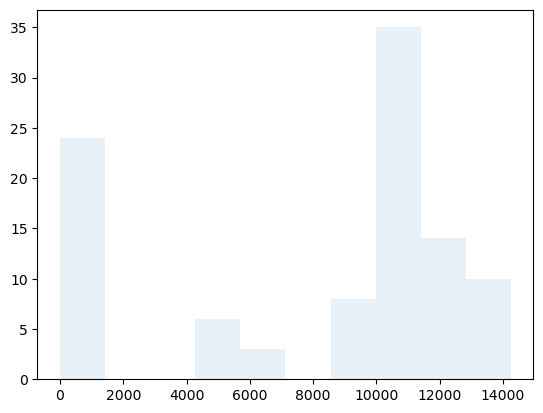

In [2]:
# GETTING SUMMARIES OF A DIRECTORY OF CAPTURES:
# nfiles, nframes, statistics
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import CSIFuncs

dirs = glob("/Volumes/tim_details/tim_honours/CAPTURES/*/*")
dirs = ["/Volumes/tim_details/tim_honours/CAPTURES/client_pi_200/v=mkWKZWMokdI"]

# Getting a summary of each different CSI experiment setup
res_arr = {}
for dir in dirs:
    print(dir)
    fps = glob(os.path.join(dir, "csi/*"))
    res_arr[dir] = CSIFuncs.get_summaries(fps)

fig, ax = plt.subplots()
for i in res_arr:
    res = res_arr[i]
    ax.hist(
        res["nframes"],
        alpha=0.2,
        label=f"{i}",
    )
# plt.legend()

In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import CSIFuncs

dirs = glob("/Volumes/tim_details/tim_honours/CAPTURES/*/*")
nframes = 10000

for dir in dirs:
    print(dir)
    fps = glob(os.path.join(dir, "csi/*"))
    comb_csi = CSIFuncs.combine_csis(fps, nframes)
    np.save(os.path.join(dir, "csi_all.npy"), comb_csi)

# fig, ax = plt.subplots()
# CSIFuncs.hist2d_subc(np.abs(csi), fig, ax)
# fig, ax = plt.subplots()
# CSIFuncs.hist2d_complex(csi, fig, ax)
# CSIFuncs.plot_all(csi)

/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=A3gUpodXMv0
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=3InbMow9IYo
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=mkWKZWMokdI
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=t634q_Voeto
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=w_oGIbFjiCo
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=yve6qo6eowU
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=gxxqdrrpgZc
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=NSW5u1RTxEA
/Volumes/tim_details/tim_honours/CAPTURES/client_pc_50/v=t6jlhqNxRYk
/Volumes/tim_details/tim_honours/CAPTURES/client_pi_50/v=3InbMow9IYo
/Volumes/tim_details/tim_honours/CAPTURES/client_pi_50/v=t634q_Voeto
/Volumes/tim_details/tim_honours/CAPTURES/client_pi_50/v=yve6qo6eowU
/Volumes/tim_details/tim_honours/CAPTURES/client_pi_50/v=NSW5u1RTxEA
/Volumes/tim_details/tim_honours/CAPTURES/client_pi_50/v=A3gUpodXMv0
/Volumes/tim_details/tim_honours/C

In [8]:
x = np.load("/Volumes/tim_details/tim_honours/CAPTURES/client_pi_200_wall/v=t6jlhqNxRYk/csi_all.npy")
x.shape

(100, 15000, 64)